**READ ME:**

    1. PLEASE READ THE COMMENTS ABOVE EVERY CELL BEFORE EXECUTING/COMPILING THE CODE
    
    2. THIS NOTEBOOK DOES THE FOLLOWING -
    
       SECTION 0: SET UP THE NOTEBOOK
       SECTION 1: CLEAN AND PROCESS THE DATA
       
   **SECTION 2: CREATE FEATURES BASED ON USER JOURNEY i.e. A USER'S INTERACTION(S) WITH A SINGLE GIVEN PRODUCT**
   
       SECTION 3: SPLITTING DATA INTO TRAIN AND TEST
       SECTION 4: FEATURE RANKING
       SECTION 5: DATA TRANSFORMATION
       SECTION 6: BASELINING
       SECTION 7: CREATING SAMPLES - NON STRATIFIED
       SECTION 8: CREATING SAMPLES - STRATIFIED
       SECTION 9: T-SNE
       SECTION 10: CLUSTERING

# 0. ***`SETUP`***

## i. SETTING UP NOTEBOOK

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
from google.colab import drive

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
%pwd
%cd drive/My Drive/Colab Notebooks/Feature Engineering

## ii. Pre-Processing : Library and Data file import

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
#display all columns in a dataframe
pd.set_option('display.max_columns', 999)
#setting default figure size
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import gc

In [4]:
import imblearn
from imblearn.over_sampling import SMOTE
import collections
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [5]:
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

### Data Import
Original CSV download

TO DOWNLOAD THE **electronics.csv** FILE PLEASE GO TO :

1. https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store
2. Download both the "2019-Nov.csv" and the "2019-Oct.csv" File
3. Combine the csv files. Combined File size should be 13.67 GB
4. For a quick tutorial on how to combine csv files on MAC please refer: https://serp.co/blog/combine-merge-csv-files-mac/

In [ ]:
## Run this cell for ELECTRONICS data ONLY
electronics = pd.read_csv("electronics.csv")

### Quick File Imports Below 

**Run the cells below if you want to download already processed/compiled data files and skip Sections 1 and 2**

Processed dataframe download

In [6]:
#Run this cell for Electronics Data ONLY
df = pd.read_pickle("dfElectronics.pkl")

Feature Dataset Quick Import

In [6]:
#Run this cell for ELECTRONICS Data ONLY
FeaturesDF = pd.read_pickle("Electronics_Journey_Features.pkl")

## iii. CHECK RAM

In [11]:
#AVAILABLE SYSTEM RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 17.2 gigabytes of available RAM



In [55]:
#garbage collection
gc.collect()

4950

#    
************************************************
************************************************

# 1. ***`PROCESSING DATA`***

Jump to Section 3 if you have alreday imported FeaturesDF files

In [9]:
#Run this cell for ELECTRONICS Data ONLY
df = electronics.copy()

In [ ]:
# Run this cell for ELECTRONICS data ONLY

df.drop('category_id',axis=1,inplace=True)

In [14]:
#Dropping rows which have headers in them
headerIndices = df[df['event_time']=='event_time'].index
df.drop(headerIndices,inplace=True)

**Formatting Date Time Column**

In [15]:
df['event_time'] = pd.to_datetime(df['event_time'],format = '%Y-%m-%d %H:%M:%S %Z')

In [16]:
#Year
df['year'] = (df['event_time']).dt.year

In [17]:
#Month
df['month'] = (df['event_time']).dt.month
MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = df['month'].map(MM)

In [18]:
# Phase of day
df['hour'] = (df['event_time']).dt.hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df['hour'].map(timeOfDay)

In [19]:
# Weekday
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = (df['event_time']).dt.weekday.map(dayOfWeek)

In [20]:
# Is Weekend?
df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

**Formatting Other Column Types**

In [ ]:
df['price']= pd.to_numeric(df['price'])

In [21]:
#DROPPING COLUMNS WHICH HAVE NEGATIVE VALUE OF PRICE
negative_price = df[df['price']<0]
negative_price = negative_price.index
df = df.drop(negative_price)

In [23]:
df['year']= pd.to_numeric(df['year'])
df['hour']= pd.to_numeric(df['hour'])
df['Weekend']= pd.to_numeric(df['Weekend'])

In [24]:
df['event_type'] = df['event_type'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['category_id'] = df['category_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['user_session'] = df['user_session'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
df['timeOfDay'] = df['timeOfDay'].astype(str)

In [27]:
#Dropping Rows where the user_session is NAN

Null_Sessions = df[df['user_session']=='nan'].index
Null_Sessions
df = df.drop(Null_Sessions)

**SAVE TO PICKLE**

In [ ]:
## Run this cell only for ELECTRONICS Data ONLY to Save and Load Pickle Files

#df.to_pickle("dfElectronics.pkl")

In [30]:
df.shape

(20688111, 13)

#    
************************************************
************************************************

# 2. **`CREATING USER JOURNEY BASED FEATURES`**

## Features to build:

     'NumOfEventsInJourney',
     'NumSessions',
     'interactionTime',
     'maxPrice',
     'minPrice',
     'NumCart',
     'NumView',
     'NumRemove',
     'InsessionCart',
     'InsessionView',
     'Date',
     'year',
     'month',
     'weekday',
     'timeOfDay',
     'Weekend',
     'Purchase'

## GROUPING THE DATA

In [7]:
GroupUJB =  df.sort_values('event_time').groupby(['user_id','product_id'])

## Total Number of Events in User Jouney

In [10]:
Features = GroupUJB['event_type'].count().reset_index()

In [11]:
Features.rename(columns={'event_type':'NumOfEventsInJourney'}, inplace=True)

## Total Number of Sessions in User Jouney

In [12]:
Features['NumSessions'] = GroupUJB['user_session'].nunique().reset_index()['user_session']

In [13]:
Features = Features.set_index(['user_id','product_id'])

In [24]:
Features.head()

NumOfEventsInJourney  NumSessions
user_id   product_id                                   
106416780 2500141                        1            1
          2501450                        2            1
107020671 6000120                        1            1
107837897 4700199                        9            8
          4700239                        1            1

## Duration

In [25]:
# Defining function to return range of any given series
def ammd(series):
    return (max(series)-min(series))

In [26]:
interactionTime = GroupUJB['event_time'].agg(ammd)

In [27]:
interactionTime = interactionTime.dt.total_seconds()

In [29]:
Features = Features.join(interactionTime, how='outer')
Features = Features.rename(columns={'event_time':'interactionTime'})

In [28]:
Features.head()

NumOfEventsInJourney  NumSessions
user_id   product_id                                   
106416780 2500141                        1            1
          2501450                        2            1
107020671 6000120                        1            1
107837897 4700199                        9            8
          4700239                        1            1

## Max and Min Price

In [30]:
Features['maxPrice'] = GroupUJB['price'].max().values
Features['minPrice'] = GroupUJB['price'].min().values

## Total Number of Events/Interactions in User Jouney

In [31]:
cart = GroupUJB['event_type'].value_counts().unstack(fill_value = 0).loc[:,'cart']
view = GroupUJB['event_type'].value_counts().unstack(fill_value = 0).loc[:,'view']

In [32]:
Features['NumCart'] = cart.values
Features['NumView'] = view.values

In [33]:
Features.head()

NumOfEventsInJourney  NumSessions  interactionTime  \
user_id   product_id                                                       
106416780 2500141                        1            1              0.0   
          2501450                        2            1             42.0   
107020671 6000120                        1            1              0.0   
107837897 4700199                        9            8        1461990.0   
          4700239                        1            1              0.0   

                      maxPrice  minPrice  NumCart  NumView  
user_id   product_id                                        
106416780 2500141       476.12    476.12        0        1  
          2501450       450.44    450.44        0        2  
107020671 6000120       139.77    139.77        0        1  
107837897 4700199       179.90    175.00        1        8  
          4700239        51.22     51.22        0        1

----

## Total Amount By Sessions for the User considered in a User Journey

In [34]:
Amount_cart = df.groupby('user_session')['event_type'].value_counts().unstack(fill_value = 0).loc[:,'cart'].to_frame().reset_index().rename(columns={'cart':'session_cart'})

In [35]:
Amount_view = df.groupby('user_session')['event_type'].value_counts().unstack(fill_value = 0).loc[:,'view'].to_frame().reset_index().rename(columns={'view':'session_view'})

In [36]:
df = pd.merge(df,Amount_cart, how='left',on = ['user_session'])

In [37]:
df = pd.merge(df,Amount_view, how='left',on = ['user_session'])

In [38]:
insessioncart = df.groupby(['user_id','product_id'])['session_cart'].max()

In [39]:
insessionview = df.groupby(['user_id','product_id'])['session_view'].max()

Merging the DataFrames

In [40]:
Features = pd.merge(Features,insessioncart, how='left',on = ['user_id','product_id'])

In [41]:
Features = pd.merge(Features,insessionview, how='left',on = ['user_id','product_id'])

In [42]:
Features = Features.rename(columns={'session_cart':'InsessionCart','session_view':'InsessionView'})

In [43]:
Features.head(3)

NumOfEventsInJourney  NumSessions  interactionTime  \
user_id   product_id                                                       
106416780 2500141                        1            1              0.0   
          2501450                        2            1             42.0   
107020671 6000120                        1            1              0.0   

                      maxPrice  minPrice  NumCart  NumView  InsessionCart  \
user_id   product_id                                                        
106416780 2500141       476.12    476.12        0        1              0   
          2501450       450.44    450.44        0        2              0   
107020671 6000120       139.77    139.77        0        1              0   

                      InsessionView  
user_id   product_id                 
106416780 2500141                 3  
          2501450                 3  
107020671 6000120                 1

****************************************

## Adding Date and Time Features 

In [44]:
Features['mostCommonDateTime'] = GroupUJB['event_time'].max().values

In [45]:
#Date
Features['Date'] = pd.to_datetime(Features['mostCommonDateTime']).dt.date

In [46]:
#Year
Features['year'] = pd.to_datetime(Features['mostCommonDateTime']).dt.year

In [47]:
#Month
Features['month'] = pd.to_datetime(Features['mostCommonDateTime']).dt.month

In [48]:
# Weekday
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
Features['weekday'] = pd.to_datetime(Features['mostCommonDateTime']).dt.weekday.map(dayOfWeek)

In [49]:
#TimeOfDay
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
Features['timeOfDay'] = pd.to_datetime(Features['mostCommonDateTime']).dt.hour.map(timeOfDay)

In [50]:
Weekend = GroupUJB['Weekend'].sum()
Features = Features.join(Weekend,how='outer')

**ONE HOT ENCODING DATE TIME COLUMN**

In [51]:
weekday = pd.get_dummies(Features['weekday'])
year = pd.get_dummies(Features['year'])
month = pd.get_dummies(Features['month'])
timeOfDay = pd.get_dummies(Features['timeOfDay'])

In [54]:
Features = Features.join(weekday,how='left')
Features = Features.join(year,how='left')
Features = Features.join(month,how='left')
Features = Features.join(timeOfDay,how='left')

In [55]:
Features.rename(columns={1:'Jan',2:'Feb',10:'Oct',11:'Nov',12:'Dec'},inplace=True)

In [70]:
Features.head(3)

NumOfEventsInJourney  NumSessions  interactionTime  \
user_id   product_id                                                       
106416780 2500141                        1            1              0.0   
          2501450                        2            1             42.0   
107020671 6000120                        1            1              0.0   

                      maxPrice  minPrice  NumCart  NumView  InsessionCart  \
user_id   product_id                                                        
106416780 2500141       476.12    476.12        0        1              0   
          2501450       450.44    450.44        0        2              0   
107020671 6000120       139.77    139.77        0        1              0   

                      InsessionView  mostCommonDateTime        Date  year  \
user_id   product_id                                                        
106416780 2500141                 3 2019-11-28 05:47:29  2019-11-28  2019   
          2501450                 3 2019-11-28 05:49:14  2019-11-28  2019   
107020671 6000120                 1 2019-11-18 03:36:08  2019-11-18  2019   

                      month weekday     timeOfDay  Weekend  Fr  Mon  Sat  Sun  \
user_id   product_id                                                            
106416780 2500141        11     Thu  EarlyMorning        0   0    0    0    0   
          2501450        11     Thu  EarlyMorning        0   0    0    0    0   
107020671 6000120        11     Mon          Dawn        0   0    1    0    0   

                      Thu  Tue  Wed  2019  Oct  Nov  Afternoon  Dawn  \
user_id   product_id                                                   
106416780 2500141       1    0    0     1    0    1          0     0   
          2501450       1    0    0     1    0    1          0     0   
107020671 6000120       0    0    0     1    0    1          0     1   

                      EarlyMorning  Evening  Morning  Night  Noon  
user_id   product_id                                               
106416780 2500141                1        0        0      0     0  
          2501450                1        0        0      0     0  
107020671 6000120                0        0        0      0     0

## Dropping redundant/non-required  Columns and adding Y label 'Purchase'

In [71]:
Features = Features.drop(['Date','mostCommonDateTime','year','month','weekday','timeOfDay'],axis=1)

In [72]:
Purchase = GroupUJB['event_type'].value_counts().unstack(fill_value = 0).loc[:,'purchase']

In [73]:
Features['Purchase']= Purchase
Features['Purchase'] = Features['Purchase'].apply(lambda x : 1 if x!=0 else 0)

In [74]:
FeaturesDF= Features.sort_values(by='Purchase',ascending=False)

In [75]:
FeaturesDF.head()

,,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,Weekend,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Oct,Nov,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
user_id,product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
558439246,1004564,5,3,43819.0,128.45,128.45,1,3,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1
541078011,1004767,5,1,317.0,240.40,240.40,1,3,1,3,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1
514764771,5801494,10,5,1019927.0,51.48,51.48,2,7,2,5,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
573939521,1004835,8,2,428149.0,231.38,231.31,2,5,2,5,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1
518624163,1005105,4,1,102.0,1415.48,1415.48,0,3,0,3,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


In [76]:
display("The features we have are as follows:", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

'The features we have are as follows:'

['NumOfEventsInJourney',
 'NumSessions',
 'interactionTime',
 'maxPrice',
 'minPrice',
 'NumCart',
 'NumView',
 'InsessionCart',
 'InsessionView',
 'Weekend',
 'Fr',
 'Mon',
 'Sat',
 'Sun',
 'Thu',
 'Tue',
 'Wed',
 2019,
 'Oct',
 'Nov',
 'Afternoon',
 'Dawn',
 'EarlyMorning',
 'Evening',
 'Morning',
 'Night',
 'Noon',
 'Purchase']

************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


**Save to Pickle**

In [77]:
#Run this cell for ELECTRONICS Data
FeaturesDF.to_pickle("Electronics_Journey_Features.pkl")

In [7]:
FeaturesDF.head()

,,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,Weekend,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Oct,Nov,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
user_id,product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
558439246,1004564,5,3,43819.0,128.45,128.45,1,3,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1
541078011,1004767,5,1,317.0,240.40,240.40,1,3,1,3,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1
514764771,5801494,10,5,1019927.0,51.48,51.48,2,7,2,5,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
573939521,1004835,8,2,428149.0,231.38,231.31,2,5,2,5,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1
518624163,1005105,4,1,102.0,1415.48,1415.48,0,3,0,3,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


#    
************************************************
************************************************

# 3. ***`SPLITTING DATA`***

## 3a. Test-Train Split

In [8]:
XData = FeaturesDF.iloc[:,:-1]
YData = FeaturesDF.iloc[:,-1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

## 3b. Scaling with MinMax

In [10]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

#    
************************************************
************************************************

# 4. ***`FEATURE RANKING`***

## 4a. Using Random Forest

In [12]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [ ]:
sel.fit(X_train, y_train)

In [ ]:
sel.get_support()

In [ ]:
selected_feat= XData.columns[(sel.get_support())]

In [ ]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## 4b. Using F Scores

In [ ]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

In [ ]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

In [ ]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

#    
************************************************
************************************************

# 5. ***` DATA TRANSFORMATION`***

## 5.1 SMOTE 

In [67]:
print( "Label Distribution Pre Balancing {}".format(Counter(YData)))

Label Distribution Pre Balancing Counter({0: 21442423, 1: 617293})


In [68]:
oversample = SMOTE()
XSMOTE, YSMOTE = oversample.fit_resample(XData, YData)

In [69]:
print( "Label Distribution Post Balancing {}".format( Counter(YSMOTE) ) )

Label Distribution Post Balancing Counter({1: 21442423, 0: 21442423})


In [70]:
trainX, testX, trainY, testY = train_test_split(XSMOTE,YSMOTE,test_size=0.2,random_state=42)

In [71]:
MMscaler = MinMaxScaler()
trainX = MMscaler.fit_transform(trainX)
testX = MMscaler.transform(testX)

**Save/load pickle files for quick future usage**

In [72]:
FeaturesDFSMOTE = pd.concat([XSMOTE,YSMOTE],axis=1)

FeaturesDFSMOTE.to_pickle('Electronics_Session_Features_SMOTE.pkl')
FeaturesDFSMOTE = pd.read_pickle('Electronics_Session_Features_SMOTE.pkl')

## 5.2 PCA

### 5.2.1 Non Balanced Data

**pca1 : Based on the explained variance percentage**

In [73]:
desiredVariancePercent = 0.8

In [74]:
pca1 = PCA()
pca1.fit(X_train)

PCA()

In [75]:
variance_cumsum = np.cumsum(pca1.explained_variance_ratio_)
variance_cumsum

array([0.21086136, 0.32214916, 0.4095742 , 0.48649043, 0.56156747,
       0.63446372, 0.69951133, 0.75938413, 0.81838954, 0.87684265,
       0.93253877, 0.96051217, 0.98380365, 0.99614895, 0.99980979,
       0.99996567, 0.99998392, 0.99999213, 0.99999756, 0.99999894,
       0.99999996, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [76]:
numRequiredComponents = next(x[0] for x in enumerate(variance_cumsum.tolist()) if (x[1]> desiredVariancePercent)) + 1
print("Number of components that explain {} percent variance in data are {}".format(desiredVariancePercent*100,numRequiredComponents))

Number of components that explain 80.0 percent variance in data are 9


**pca2 : Number of components defined for variance specified above**

In [77]:
pca2 = PCA(n_components=numRequiredComponents)
pca2.fit(X_train)

PCA(n_components=9)

In [78]:
np.cumsum(pca2.explained_variance_ratio_)

array([0.21086136, 0.32214916, 0.4095742 , 0.48649043, 0.56156747,
       0.63446372, 0.69951133, 0.75938413, 0.81838954])

**pcaNC2 : Number of components = 2**

In [79]:
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(X_train)

PCA(n_components=2)

**Visualization of Explained Variance Ratio For different components**

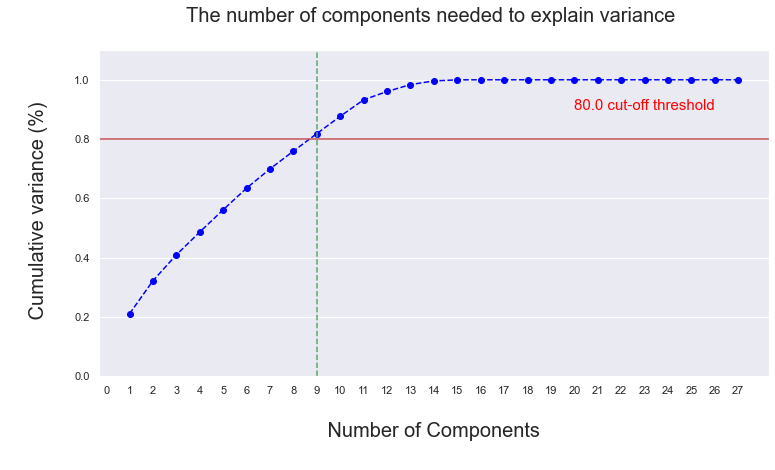

In [80]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, FeaturesDF.shape[1], step=1)
y = np.cumsum(pca1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, FeaturesDF.shape[1], step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=numRequiredComponents, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.2 Balanced Data

**smote_pca : Number of components NOT defined**

In [81]:
smote_pca = PCA()
smote_pca.fit(trainX)

PCA()

In [82]:
variance_cumsumSMOTE = np.cumsum(smote_pca.explained_variance_ratio_)

In [83]:
numRequiredComponentsSMOTE = next(x[0] for x in enumerate(variance_cumsumSMOTE.tolist()) if (x[1]> desiredVariancePercent)) + 1
print("Number of components that explain {} percent variance in data are {}".format(desiredVariancePercent*100,numRequiredComponentsSMOTE))

Number of components that explain 80.0 percent variance in data are 10


**smote_pca2 : Number of components defined for variance specified**

In [84]:
smote_pca2 = PCA(n_components=numRequiredComponentsSMOTE)
smote_pca2.fit(trainX)

PCA(n_components=10)

**smotePcaNC2 : Number of components = 2**

In [85]:
smote_pcaNC2 = PCA(n_components=2)
smote_pcaNC2.fit(X_train)

PCA(n_components=2)

**SMOTE PCA Visualization**

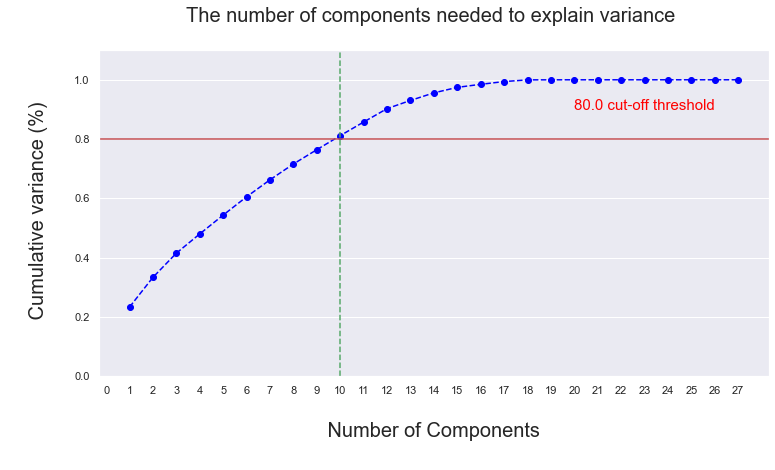

In [86]:
fig, ax = plt.subplots()
xi = np.arange(1, FeaturesDF.shape[1], step=1)
y = np.cumsum(smote_pca.explained_variance_ratio_)
NTH_component = next(x[0] for x in enumerate(y.tolist()) if (x[1]> desiredVariancePercent))

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, FeaturesDF.shape[1], step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=NTH_component+1, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.3 PCA Transformations

Non Balanced Data --- 

CHOOSE the function you want to use depending on variance/number of components :

1. pca1
2. pca2
3. pcaNC2

In [87]:
X_train_pca = pca2.transform(X_train)
X_test_pca = pca2.transform(X_test)

In [88]:
X_PCA = np.concatenate([X_train_pca,X_test_pca])

In [89]:
X_PCA.shape

(22059716, 9)

Balanced Data

In [90]:
trainX = smote_pca2.transform(trainX)
testX = smote_pca2.transform(testX)

In [91]:
trainX.shape

(34307876, 10)

#    
************************************************
************************************************

# 6. ***`BASELINING`***

## 6a. BASELINING --- non Balanced data

In [92]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [ ]:
y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)

In [ ]:
print(metrics.accuracy_score(y_train, y_pred))

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_predFinal = logreg.predict(X_test)

In [ ]:
print(metrics.accuracy_score(y_test, y_predFinal))

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predFinal)
cnf_matrix

In [ ]:
class_names=[1,0] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predFinal))
print("Precision:",metrics.precision_score(y_test, y_predFinal))
print("Recall:",metrics.recall_score(y_test, y_predFinal))

## 6b. BASELINING - Balanced data

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [ ]:
predY = cross_val_predict(logreg, trainX, trainY, cv=5)

In [ ]:
print(metrics.accuracy_score(trainY, predY))

In [ ]:
logreg.fit(trainX, trainY)

In [ ]:
predFinalY = logreg.predict(testX)

In [ ]:
print(metrics.accuracy_score(testY, predFinalY))

In [ ]:
cnf_matrix_SMOTE = metrics.confusion_matrix(testY, predFinalY)
cnf_matrix_SMOTE

In [ ]:
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_SMOTE), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix SMOTE',size = 20)
plt.ylabel('Actual label SMOTE ',size = 20)
plt.xlabel('Predicted label SMOTE',size = 20)

In [ ]:
print("Accuracy:",metrics.accuracy_score(testY, predFinalY))
print("Precision:",metrics.precision_score(testY, predFinalY))
print("Recall:",metrics.recall_score(testY, predFinalY))

#    
************************************************
************************************************

# 7. ***`SUBSETTING DATA/CREATING SAMPLES`***

NON STRATIFIED

    FeaturesDF - All Features
    XData, YData - FeaturesDF split into x and y
    X,Y - SMOTE of XData and YData
    XSelect,YSelect- XData with select features
    XSample,YSample - XSelect Sliced upto 'n' rows non stratified

In [ ]:
print(XData.shape)
print(YData.shape)

In [ ]:
# FOR COSMETICS DATA

SelectFeatures = ['NumOfEventsInJourney',          'NumSessions',      'interactionTime',
                   'maxPrice',             'minPrice',              'NumCart',
                    'NumView',     'InsessionCart', 'InsessionView',      ]

**Subsets for clustering**

In [ ]:
#Enter the desired subset size

Subset_size = XData.shape[0] # All Rows

# OR

Subset_size = 60000 # Specified number of rows

In [ ]:
#CREATING X SAMPLE

XSelect = XData[SelectFeatures]
XSample = XSelect[:Subset_size].iloc[:,:]

In [ ]:
#Scaling X SAMPLE

MMscaler = MinMaxScaler()
SampleCol = XSample.columns
XSample = MMscaler.fit_transform(XSample)
XSample = pd.DataFrame(XSample,columns=SampleCol)

print(XSample.shape)

In [ ]:
#CREATING Y SAMPLE

YSample = YData[:Subset_size]
print(YSample.value_counts())

#    
************************************************
************************************************

# 8. ***`STRATIFIED SAMPLING`***

XSampleSS - Stratified X Sample

YSampleSS - Stratified Y Sample


## Generating Sample

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.006, random_state=42)


In [22]:
for train_index, test_index in sss.split(XData, YData):
    #print(train_index, test_index )
    XSSS_Train = XData.reset_index().loc[train_index]
    XSSS_Test = XData.reset_index().loc[test_index]
    YSSS_Train = YData.reset_index().loc[train_index]
    YSSS_Test = YData.reset_index().loc[test_index]

In [23]:
XSampleSS = XSSS_Test
print(XSampleSS.shape)
YSampleSS = YSSS_Test
print(YSampleSS.shape)

(132359, 29)
(132359, 3)


In [28]:
# FOR ELECTRONICS DATA


SelectFeatures = ['NumOfEventsInJourney',          'NumSessions',      'interactionTime',
                   'maxPrice',             'minPrice',              'NumCart',
                    'NumView',                    'InsessionCart',  'InsessionView' ]

In [29]:
#Creating Stratified X Sample

XSampleSS = XSampleSS[SelectFeatures]

XSampleSS = XSampleSS.iloc[:,:]
SampleColSS = XSampleSS.columns

XSampleSS = MMscaler.fit_transform(XSampleSS)
XSampleSS = pd.DataFrame(XSampleSS,columns=SampleColSS)

In [30]:
#Creating Stratified Y Sample
YSampleSS = YSampleSS.Purchase

#    
************************************************
************************************************

# 9. ***`T-SNE`***

## T-SNE FUNCTIONS SETUP

In [56]:
def generate_tsne(sample_X, sample_Y, perp):
    
    """
    Parameter : Perplexity (5 to 50, increase with density)
    Returns: tsne modified dataframe
    """
    
    tsne = TSNE(n_components=2, perplexity = perp, n_iter = 300, learning_rate=100)
    tsne_results = tsne.fit_transform(sample_X)
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1','comp2'])
    df_tsne['label'] = sample_Y.values
    return df_tsne

In [32]:
def viz_TSNE(df_tsne):
    
    """
    Parameter :tsne modified dataframe
    Returns: Visualization of tsne
    """
    
    plt.figure(figsize=(9,6))
    sns.lmplot(x='comp1', y='comp2', data = df_tsne, hue='label', fit_reg=False)
    plt.show()

## **TSNE ITERATIONS**

### Trial 1

Using a Stratified Sample

(n_components=2, perplexity = perp, n_iter = 1000, learning_rate=100)


***1.1
Perplexity = 10***

In [33]:
dfSS10 = generate_tsne(XSampleSS, YSampleSS, 10)

<Figure size 648x432 with 0 Axes>

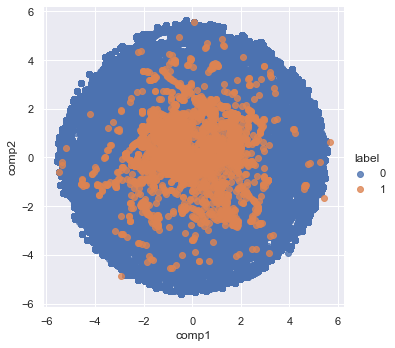

In [34]:
viz_TSNE(dfSS10)

***1.2
Perplexity = 20***

In [ ]:
dfSS20= generate_tsne(XSampleSS, YSampleSS, 20)b

In [ ]:
viz_TSNE(dfSS20)

***1.3
Perplexity = 30***

In [35]:
dfSS30= generate_tsne(XSampleSS, YSampleSS, 30)

<Figure size 648x432 with 0 Axes>

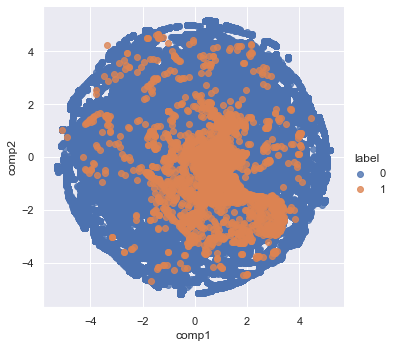

In [36]:
viz_TSNE(dfSS30)

***1.4
Perplexity = 50***

In [ ]:
dfSS50= generate_tsne(XSampleSS, YSampleSS, 50)

In [ ]:
viz_TSNE(dfSS50)

#    
************************************************
************************************************

# 10. ***`CLUSTERING`***

## DBSCAN FUNCTION

In [37]:
def dbscan(X, eps, min_samples):
    """
    Parameters: 
    X: the X dataframe for clustering
    eps : min distance between points in a cluster
    min_samples: min number of data points in a sample
    
    Returns:
        A DBSCAN visualiazation
        Estimated number of clusters
    """   
    
    X = X.iloc[:,:].values
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    print('Estimated number of clusters: %d' % n_clusters_)

####  *Finding Optimal Eps value for DBSCAN*

In [39]:
NN = NearestNeighbors(n_neighbors=1000)
nbrs = NN.fit(XSampleSS)

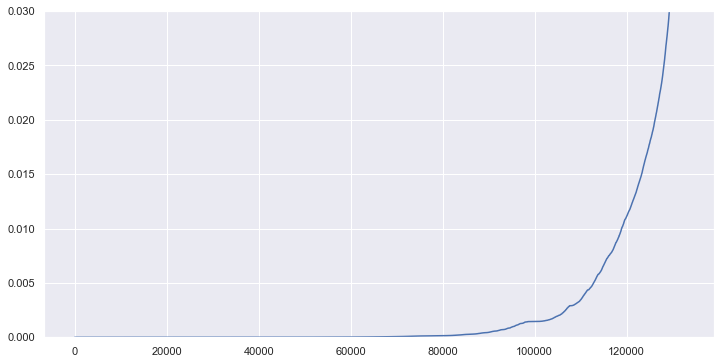

In [40]:
distances, indices = nbrs.kneighbors(XSampleSS)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim([0,0.05])
plt.show()

## CLUSTERING after PCA

In [41]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

PCA(n_components=2)

In [42]:
# Transforming the stratified sample through PCA
XSampleSS_pca = pcaNC2.transform(XSampleSS)

Estimated number of clusters: 9


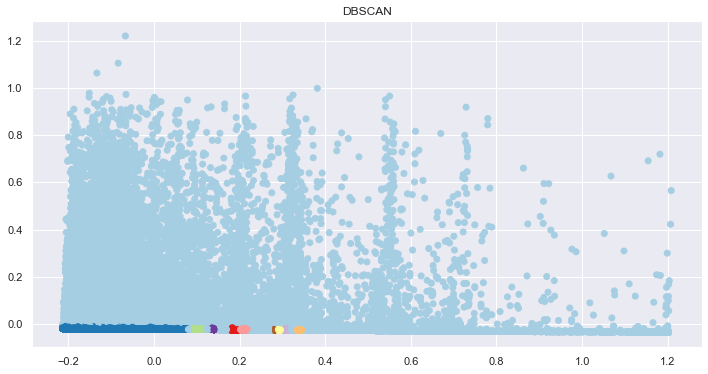

In [43]:
#RUNNING DBSCAN WITH EPS = 0.005

dbscan(pd.DataFrame(XSampleSS_pca),0.005,1000)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.005 AND MIN_SAMPLE = 100

dbscan(pd.DataFrame(XSampleSS_pca),0.005,100)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.03

dbscan(pd.DataFrame(XSampleSS_pca),0.03,1000)

## CLUSTERING after TSNE

Estimated number of clusters: 0


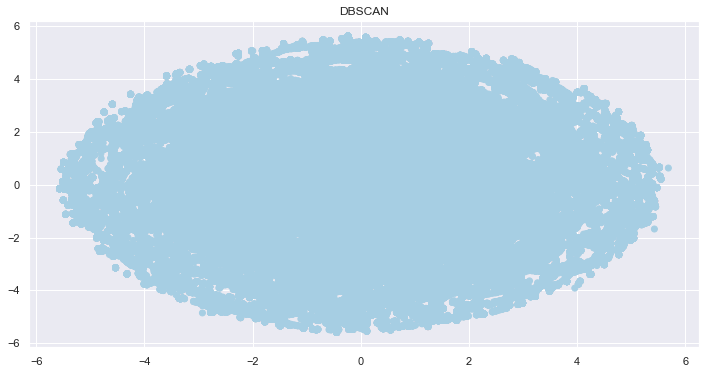

In [46]:
dfX10 = dfSS10.loc[:,:'comp2']
dbscan(dfX10, 0.003, 1000)

In [ ]:
dfX20 = dfSS20.loc[:,:'comp2']
dbscan(dfX20, 0.007, 1000)

Estimated number of clusters: 0


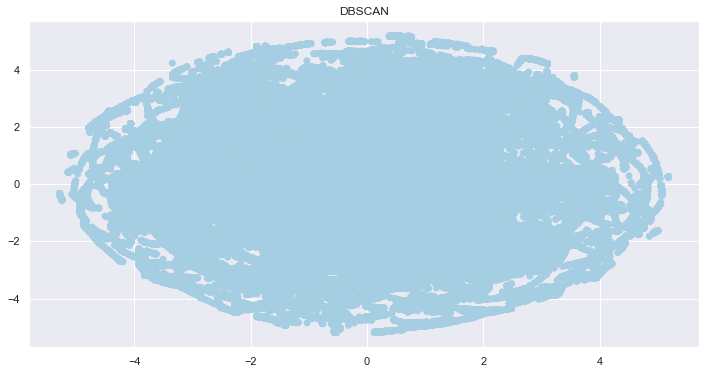

In [45]:
dfX30 = dfSS30.loc[:,:'comp2']
dbscan(dfX30, 0.005, 1000)

## CLUSTERING after PCA + TSNE

**STEP 1 PCA**

In [49]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

PCA(n_components=2)

In [50]:
# Transforming the stratified sample through PCA
XSS_pca = pcaNC2.transform(XSampleSS)

**STEP 2 TSNE**

In [51]:
# Running TSNE with perplexity = 20
df_tsne_pca = generate_tsne(XSS_pca, YSampleSS, 20)

<Figure size 648x432 with 0 Axes>

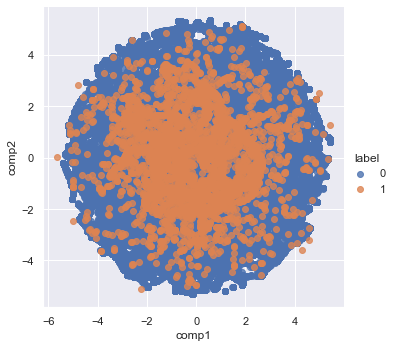

In [52]:
viz_TSNE(df_tsne_pca)

**STEP 3 Cluster Visualizations**

Estimated number of clusters: 0


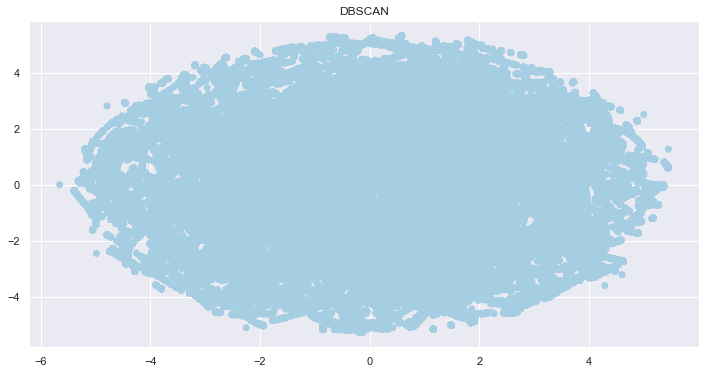

In [53]:
#clustering using DBSCAN with eps = 0.03 and min_sample = 1000
dbscan(pd.DataFrame(df_tsne_pca),0.05,1000)

#    
************************************************
************************************************